### CIFAR10 Experiments

In [138]:
import time
import math
from copy import deepcopy
import os
os.environ['CUDA_VISIBLE_DEVICES']='2'

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.autograd import Variable

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
import torchvision.datasets as dsets
import torchvision.transforms as trans

from models import TwoLayerNet

# mean = [0.4913997551666284, 0.48215855929893703, 0.4465309133731618]
# std = [0.24703225141799082, 0.24348516474564, 0.26158783926049628]

BATCH_SIZE = 50


# 使用数据增强
train_set = dsets.MNIST(root='./data/mnist/',
                          train=True,
                          transform=trans.Compose([
                              trans.ToTensor()
                          ]),download=True)
train_dl = DataLoader(train_set,batch_size=BATCH_SIZE,shuffle=True,num_workers=6)
train_set.train_data = train_set.train_data[0:100]
train_set.train_labels = train_set.train_labels[0:100]

# 测试集一样
test_set = dsets.MNIST(root='./data/mnist/',
                         train=False,
                         transform=trans.Compose([
                             trans.ToTensor()
                         ]),download=True)
test_dl = DataLoader(test_set,batch_size=BATCH_SIZE,shuffle=False,num_workers=6)

In [120]:
def eval(model,criterion,dataloader):
    model.eval()
    loss = 0
    accuracy = 0
    for batch_x, batch_y in dataloader:
        batch_x = Variable(batch_x.cuda())
        batch_y = Variable(batch_y.cuda())
        
        logits = model(batch_x)
        error = criterion(logits,batch_y)
        loss += error.data[0]
        
        probs,pred_y = logits.data.max(dim=1)
        accuracy += (pred_y==batch_y.data).sum()/batch_y.size(0)
        
    loss /= len(dataloader)
    accuracy = accuracy*100.0/len(dataloader)
    return loss, accuracy

def train_epoch(model,criterion,optimizer,dataloader,lmbd=0.0):
    model.train()
    for batch_x,batch_y in dataloader:
        batch_x = Variable(batch_x.cuda())
        batch_y = Variable(batch_y.cuda())

        optimizer.zero_grad()
        logits = model(batch_x)
        error = criterion(logits,batch_y) + lmbd * model.path_norm()
        error.backward()
        optimizer.step()

In [122]:
m = 100000
nepochs = 30
lr = 0.1
lmbd = math.log10(3*32*32)/60000*4


net = TwoLayerNet(784,m,10)
net = net.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(),lr=lr,momentum=0.9,nesterov=True,weight_decay=0.0)
scheduler = lr_scheduler.MultiStepLR(optimizer,milestones=[20,28],gamma=0.1)
records = []

print('开始训练网络.....')
for epoch in range(nepochs):
    since = time.time()
    scheduler.step()
    current_lr = scheduler.get_lr()[0]
    
    train_epoch(net,criterion,optimizer,train_dl,lmbd=1e-4)
    tr_loss, tr_acc = eval(net,criterion,train_dl)
    te_loss, te_acc = eval(net,criterion,test_dl)
    
    now = time.time()
    records.append((tr_loss,tr_acc,te_loss,te_acc))
    print('[%3d/%d, %.0f seconds]|\t lr=%.2e,  tr_err: %.1e, tr_acc: %.2f |\t te_err: %.1e, te_acc: %.2f'%(
        epoch+1,nepochs,now-since,current_lr,tr_loss,tr_acc,te_loss,te_acc))

开始训练网络.....
[  1/30, 2 seconds]|	 lr=1.00e-01,  tr_err: 4.1e-01, tr_acc: 93.00 |	 te_err: 6.4e-01, te_acc: 84.65
[  2/30, 2 seconds]|	 lr=1.00e-01,  tr_err: 3.2e-01, tr_acc: 94.00 |	 te_err: 5.1e-01, te_acc: 85.96
[  3/30, 2 seconds]|	 lr=1.00e-01,  tr_err: 2.8e-01, tr_acc: 94.10 |	 te_err: 4.6e-01, te_acc: 87.27
[  4/30, 2 seconds]|	 lr=1.00e-01,  tr_err: 2.4e-01, tr_acc: 95.40 |	 te_err: 4.7e-01, te_acc: 85.79
[  5/30, 2 seconds]|	 lr=1.00e-01,  tr_err: 2.0e-01, tr_acc: 96.30 |	 te_err: 4.3e-01, te_acc: 87.12
[  6/30, 2 seconds]|	 lr=1.00e-01,  tr_err: 1.5e-01, tr_acc: 97.60 |	 te_err: 4.1e-01, te_acc: 87.66
[  7/30, 2 seconds]|	 lr=1.00e-01,  tr_err: 1.3e-01, tr_acc: 98.50 |	 te_err: 4.1e-01, te_acc: 87.08
[  8/30, 2 seconds]|	 lr=1.00e-01,  tr_err: 1.1e-01, tr_acc: 98.50 |	 te_err: 4.0e-01, te_acc: 88.05
[  9/30, 2 seconds]|	 lr=1.00e-01,  tr_err: 9.3e-02, tr_acc: 99.50 |	 te_err: 4.0e-01, te_acc: 87.84
[ 10/30, 2 seconds]|	 lr=1.00e-01,  tr_err: 8.2e-02, tr_acc: 99.80 |	 te_err: 4

In [100]:
net.path_norm()

Variable containing:
 1018.7504
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [7]:
net = TwoLayerNet(14*14,m,10)

In [13]:
net

TwoLayerNet(
  (fc1): Linear(in_features=196, out_features=10000, bias=True)
  (fc2): Linear(in_features=10000, out_features=10, bias=False)
)

In [38]:
import os
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

In [139]:
filenames_raw = os.listdir('./checkpoints/mnist_100/')
res  = defaultdict(list)

i = 0
for filename in filenames_raw:
    if filename.startswith('cifar'):
        continue
    dd = filename.split('_')
    width = int(dd[1][5:])
    lmbd = float(dd[2][4:])
    net = TwoLayerNet(784,width,10)
    net.load_state_dict(torch.load('checkpoints/mnist_100/'+filename))
    net = net.cuda()
    
    pthnorm = net.path_norm().data[0]
    tr_loss, tr_acc = eval(net,criterion,train_dl)
    te_loss, te_acc = eval(net,criterion,test_dl)
    
    res[lmbd].append((width,pthnorm,tr_acc,te_acc,tr_loss,te_loss))
    
    print('finish %d-th'%(i+1))
    i+=1
    

finish 1-th
finish 2-th
finish 3-th
finish 4-th
finish 5-th
finish 6-th
finish 7-th
finish 8-th
finish 9-th
finish 10-th
finish 11-th
finish 12-th
finish 13-th
finish 14-th
finish 15-th
finish 16-th
finish 17-th
finish 18-th
finish 19-th
finish 20-th
finish 21-th
finish 22-th
finish 23-th
finish 24-th
finish 25-th
finish 26-th
finish 27-th


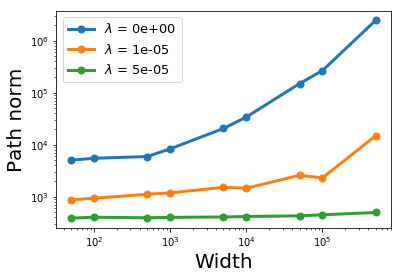

In [140]:
for lmbd,data in res.items():
    data = sorted(data,key=lambda t:t[0])
    width,pthnorm,tr_acc,te_acc,tr_loss,te_loss = zip(*data)
    
    plt.loglog(width,pthnorm,'-o',lw=3,markersize=7,label='$\lambda$ = %.0e'%(lmbd))

plt.legend(fontsize=13,loc=2)
plt.xlabel('Width',fontsize=20)
plt.ylabel('Path norm',fontsize=20)
plt.savefig('figures/mnist100_width_vs_pathnorm.png',bbox_inches='tight')

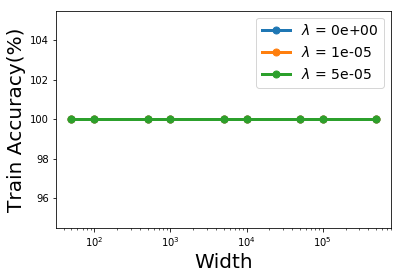

In [141]:
for lmbd,data in res.items():
    data = sorted(data,key=lambda t:t[0])
    width,pthnorm,tr_acc,te_acc,tr_loss,te_loss = zip(*data)
    
    plt.semilogx(width,tr_acc,'-o',lw=3,markersize=7,label='$\lambda$ = %.0e'%(lmbd))

plt.legend(fontsize=14)
plt.xlabel('Width',fontsize=20)
plt.ylabel('Train Accuracy(%)',fontsize=20)
plt.savefig('figures/mnist100_width_vs_tracc.png',bbox_inches='tight')

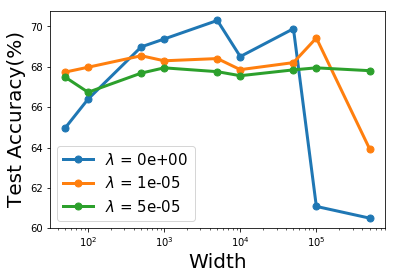

In [142]:
for lmbd,data in res.items():
    data = sorted(data,key=lambda t:t[0])
    width,pthnorm,tr_acc,te_acc,tr_loss,te_loss = zip(*data)
    
    plt.semilogx(width,te_acc,'-o',lw=3,markersize=7,label='$\lambda$ = %.0e'%(lmbd))

plt.legend(fontsize=15)
plt.xlabel('Width',fontsize=20)
plt.ylabel('Test Accuracy(%)',fontsize=20)
plt.savefig('figures/mnist100_width_vs_teacc.png',bbox_inches='tight')

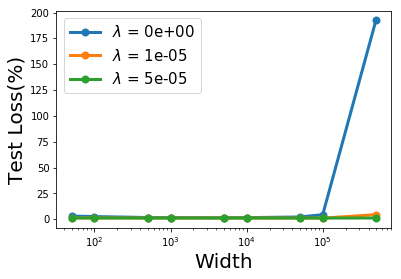

In [143]:
for lmbd,data in res.items():
    data = sorted(data,key=lambda t:t[0])
    width,pthnorm,tr_acc,te_acc,tr_loss,te_loss = zip(*data)
    
    plt.semilogx(width,te_loss,'-o',lw=3,markersize=7,label='$\lambda$ = %.0e'%(lmbd))

plt.legend(fontsize=15)
plt.xlabel('Width',fontsize=20)
plt.ylabel('Test Loss(%)',fontsize=20)
plt.savefig('figures/mnist100_width_vs_teloss.png',bbox_inches='tight')

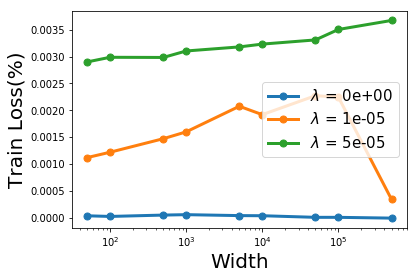

In [144]:
for lmbd,data in res.items():
    data = sorted(data,key=lambda t:t[0])
    width,pthnorm,tr_acc,te_acc,tr_loss,te_loss = zip(*data)
    
    plt.semilogx(width,tr_loss,'-o',lw=3,markersize=7,label='$\lambda$ = %.0e'%(lmbd))

plt.legend(fontsize=15)
plt.xlabel('Width',fontsize=20)
plt.ylabel('Train Loss(%)',fontsize=20)
plt.savefig('figures/mnist100_width_vs_trloss.png',bbox_inches='tight')